In [1]:
#### Import necessary packages 

import pandas as pd                   # panda is a package for data analysis and manipulation
import matplotlib.pyplot as plt       # matplotlib is the OG python plotting library and really useful for formatting
import numpy as np                    # numpy is used to perform a wide variety of mathematical operations on arrays
import seaborn as sns                 # seaborn is a package for data visualization 

In [2]:
## Import CTD sensor data as a dataframe

## This data was extracted from the 2021 GEOTRACES IDP webODV tool and downloaded as a txt file:  https://geotraces.webodv.awi.de/login
sensor = pd.read_csv("C:/Users/nicol/OEAS_895/capstone_project/raw_data/IDP2021_sensors.txt", sep = '\t', skiprows = 25, low_memory = False)


# print labels of columns from the imported dataframe 

print(sensor.columns)

Index(['Cruise', 'Station', 'Type', 'yyyy-mm-ddThh:mm:ss.sss',
       'Longitude [degrees_east]', 'Latitude [degrees_north]',
       'CTDPRS_T_VALUE_SENSOR [dbar]', 'QV:SEADATANET',
       'CTDTMP_T_VALUE_SENSOR [deg C]', 'QV:SEADATANET.1',
       'CTDSAL_D_CONC_SENSOR [pss-78]', 'QV:SEADATANET.2',
       'CTDOXY_D_CONC_SENSOR [umol/kg]', 'QV:SEADATANET.3',
       'CTDCHLA_T_CONC_SENSOR [mg/m^3]', 'QV:SEADATANET.4',
       'CTDFLUOR_T_VALUE_SENSOR [arbitrary units]', 'QV:SEADATANET.5',
       'CTDBEAMCP_T_VALUE_SENSOR [1/m]', 'QV:SEADATANET.6',
       'CTDPAR_T_VALUE_SENSOR [arbitrary units]', 'QV:SEADATANET.7',
       'QV:ODV:SAMPLE'],
      dtype='object')


In [3]:
# Since I only care about phytoplankton biomass in the surface waters, remove all data below 150 db

sensor_150 = sensor[(sensor['CTDPRS_T_VALUE_SENSOR [dbar]']<150)]

In [4]:
### Shout out to Kristina for helping automate this code
### When using the defined function 'CruiseFilter', and giving it a dataframe, a column name, and cruise identifer, it will 
### filter the rows and pull only those that have that 'cruise identifier' in that dataframe.

def CruiseFilter(sensor_150, column, cruise): 
    cruise = sensor_150[sensor_150[column].str.contains(cruise)]
    cruise.describe()
    return(cruise)

In [5]:
### Separating the cruises from this dataset
### ONLY looking at those with chlorophyll data - ignore fluorescence

GA02 = CruiseFilter(sensor_150, 'Cruise','GA02')
GA10 = CruiseFilter(sensor_150, 'Cruise','GA10')


In [6]:
# Find the minimum beam attenuation values 

GA02_beamcp_min = min(GA02['CTDBEAMCP_T_VALUE_SENSOR [1/m]'])
GA10_beamcp_min = min(GA10['CTDBEAMCP_T_VALUE_SENSOR [1/m]'])

l1 = ['GA02','GA10']
l2 = [GA02_beamcp_min, GA10_beamcp_min]

cruise_beamcp_min = pd.DataFrame(list(zip(l1, l2))) 
cruise_beamcp_min.columns = ['Cruise','Minimum Beam cp']

# print dataframe that displays the minimum beam attenuation valeus calculated for each cruise
cruise_beamcp_min

,Cruise,Minimum Beam cp
0,GA02,0.03400
1,GA10,-0.05309


In [7]:
#### For loop that steps through the minimum beam cp table to pulls values where a negative beam attenuation value found 

# Create an empty list
BeamCP_list = []
cruise_list = []


# print only the negative values from the beam cp minimums calculated

for i, row in cruise_beamcp_min.iterrows():      # Initialize for loop
    if row['Minimum Beam cp'] < 0:               
        BeamCP_list.append(row['Minimum Beam cp'])
        cruise_list.append(row['Cruise'])
        print('Index', i, '- Cruise:', row['Cruise'], '- Minimum Beam cp:', row['Minimum Beam cp'])


# changes the cruise list to a string so I can use it in the for loop for 'in' statement
cruise_list = ''.join(cruise_list)


Index 1 - Cruise: GA10 - Minimum Beam cp: -0.05309


In [8]:
# For loop that applies the absolute value of the minimum beam attenuation only to cruises that indicated 
# a negative beam attenuation value in the previous cell

# create the variable called offset that looks at the original beam attenuation data and applies the offset to necessary cruises
for index, row in sensor_150.iterrows():
    if cruise_list in row['Cruise']:
        offset = sensor_150['CTDBEAMCP_T_VALUE_SENSOR [1/m]'] + np.abs(BeamCP_list) # this creates a list with as many rows as sensor_150

# This coverts the new variable 'offset' to a dataframe so we can replace the previous column
offset = pd.DataFrame(offset)

In [9]:
# repalce rows where cruise needs offset applied

sensor_150['CTDBEAMCP_T_VALUE_SENSOR [1/m]'] = offset['CTDBEAMCP_T_VALUE_SENSOR [1/m]']

### check that it replaced ['CTDBEAMCP_T_VALUE_SENSOR [1/m]'] column with updated column 
### (if there were negative beam cp before, then the new minumum for beam cp should be zero)
sensor_150.describe()

C:\Users\nicol\AppData\Local\Temp\ipykernel_7412\2562659864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_150['CTDBEAMCP_T_VALUE_SENSOR [1/m]'] = offset['CTDBEAMCP_T_VALUE_SENSOR [1/m]']


,Longitude [degrees_east],Latitude [degrees_north],CTDPRS_T_VALUE_SENSOR [dbar],QV:SEADATANET,CTDTMP_T_VALUE_SENSOR [deg C],QV:SEADATANET.1,CTDSAL_D_CONC_SENSOR [pss-78],QV:SEADATANET.2,CTDOXY_D_CONC_SENSOR [umol/kg],QV:SEADATANET.3,CTDCHLA_T_CONC_SENSOR [mg/m^3],QV:SEADATANET.4,CTDFLUOR_T_VALUE_SENSOR [arbitrary units],QV:SEADATANET.5,CTDBEAMCP_T_VALUE_SENSOR [1/m],QV:SEADATANET.6,CTDPAR_T_VALUE_SENSOR [arbitrary units],QV:SEADATANET.7,QV:ODV:SAMPLE
count,114809.000000,114809.000000,114809.000000,114809.000000,114717.000000,114809.000000,114678.000000,114809.000000,86699.000000,114809.000000,23554.000000,114809.000000,90853.000000,114809.000000,67817.000000,114809.000000,1173.000000,114809.000000,114809.0
mean,271.852794,-9.609963,76.170087,0.512817,15.709658,0.515587,35.402920,0.518156,199.038685,2.630917,0.130561,7.320454,0.404461,1.881821,0.149168,3.865037,0.004147,8.908047,1.0
std,80.206900,37.445259,42.168642,0.499838,10.089875,0.554487,1.117726,0.578308,53.667130,3.655826,0.216123,3.310607,1.005118,3.656777,0.073597,4.296370,0.014697,0.905056,0.0
min,0.000000,-70.574900,0.000000,0.000000,-1.870000,0.000000,28.455000,0.000000,-5.118000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,237.499600,-44.660400,40.000000,0.000000,5.446000,0.000000,34.469002,0.000000,194.200000,0.000000,0.030000,9.000000,0.033000,0.000000,0.108090,0.000000,0.000000,9.000000,1.0
50%,296.242610,-11.670600,76.000000,1.000000,18.899900,1.000000,35.547001,1.000000,207.300000,1.000000,0.060000,9.000000,0.066000,0.000000,0.129090,1.000000,0.000000,9.000000,1.0
75%,320.569000,24.000000,113.000000,1.000000,24.097000,1.000000,36.252800,1.000000,221.800000,1.000000,0.130000,9.000000,0.250000,0.000000,0.168090,9.000000,0.001000,9.000000,1.0
max,359.999910,64.000300,149.910000,1.000000,30.021600,9.000000,37.638000,9.000000,387.301000,9.000000,2.340000,9.000000,10.000000,9.000000,3.185377,9.000000,0.174000,9.000000,1.0


In [10]:
######## Because not all cruises using the same CTD biological sensors, I want to look at the range of any and 
######## all biologcial sensors available against beam attenuatin data. 

######## Scatterplots created below just for initial exploratory data analysis


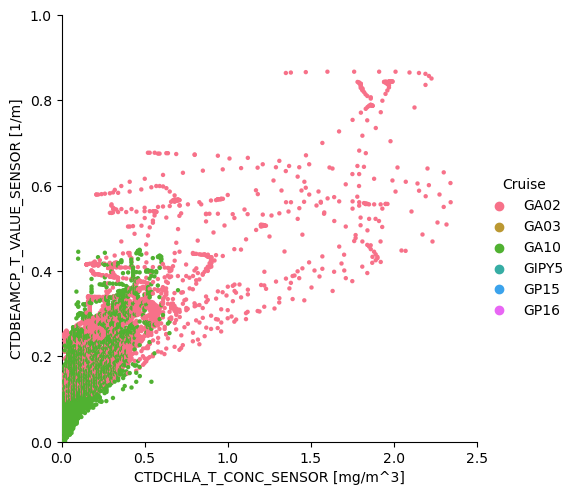

In [11]:
# This creates a categorical scatterplot for chlorophyll sensor data vs beam attenuation for cruises that had both variables

sns.color_palette("husl", 9)

g = sns.catplot(x = 'CTDCHLA_T_CONC_SENSOR [mg/m^3]', y = 'CTDBEAMCP_T_VALUE_SENSOR [1/m]', hue = 'Cruise', data = sensor_150, native_scale=True, palette = 'husl', s = 10)

g.set(xlim=(0,2.5), ylim=(0,1))

In [12]:
######## This shows that only 2 of the cruises imported had chlorophyll and beam attenuation data. 
######## I am ignoring fluorescence in this model because the range of values in the datasets varies 
######## and needs to be scaled for future use. 


C:\Users\nicol\AppData\Local\Temp\ipykernel_7412\3615832631.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = sensor_150.corr(method='pearson')


<Axes: >

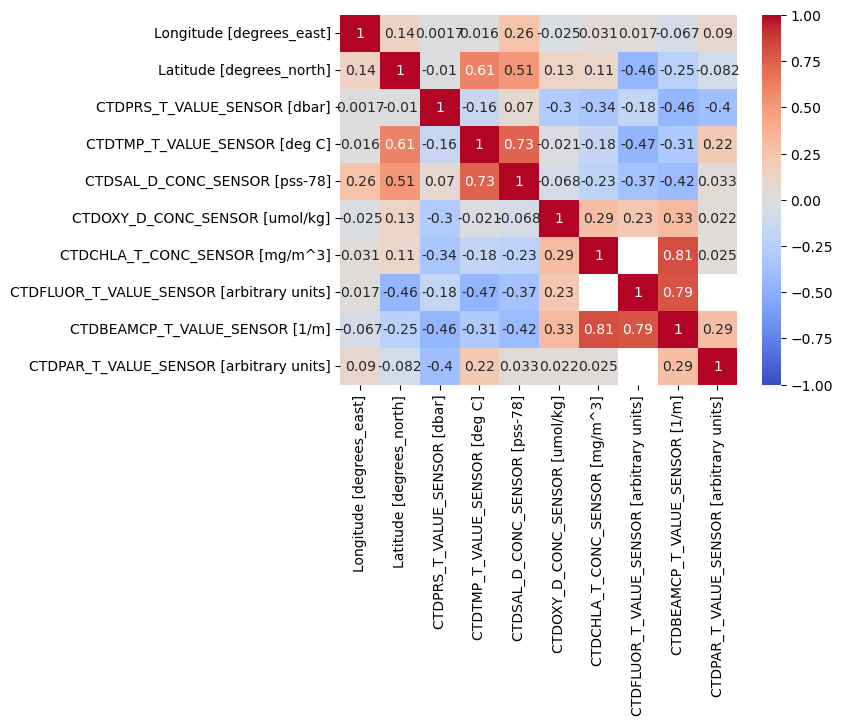

In [13]:
####### Make a correlation heat map to look at the correlation of other imported parameters with beam attenuation.
####### Gives a rough idea of the correlation between beam attenuation and chlorophyll fluorescence and other potnetial 
####### paramters to consider in future models.


### Create a new dataframe that doesn't have the data flag columns (so they don't show up in the matrix)
sensor_150 = sensor_150.drop(['QV:SEADATANET', 'QV:SEADATANET.1', 'QV:SEADATANET.2', 'QV:SEADATANET.3', 'QV:SEADATANET.4', 'QV:SEADATANET.5', 'QV:SEADATANET.6', 'QV:SEADATANET.7', 'QV:ODV:SAMPLE'], axis=1)

correlation = sensor_150.corr(method='pearson')

import matplotlib.colors as colors
from matplotlib import cm
cmap = cm.coolwarm

sns.heatmap(correlation, annot=True, norm=colors.CenteredNorm(), cmap=cmap)

In [14]:
## Drop all rows that have a NaN in either chl or beam attenuation

chl_150 = sensor_150.dropna(subset=['CTDCHLA_T_CONC_SENSOR [mg/m^3]','CTDBEAMCP_T_VALUE_SENSOR [1/m]'])



In [15]:
## make the dataframe first then add columns
## create new dataframe that only has the variables of interest in later sections
mod_sensor = pd.concat([chl_150['Cruise'], chl_150['CTDCHLA_T_CONC_SENSOR [mg/m^3]'], chl_150['CTDBEAMCP_T_VALUE_SENSOR [1/m]']], axis = 1)


## adding column name to the respective columns
mod_sensor.columns =['Cruise', 'Chlorohyll a [mg/m^3]', 'Beam Attenuation [1/m]']


## resets the indices for later use
mod_sensor = mod_sensor.reset_index()


mod_sensor

,index,Cruise,Chlorohyll a [mg/m^3],Beam Attenuation [1/m]
0,0,GA02,0.04,0.12109
1,1,GA02,0.04,0.12109
2,2,GA02,0.04,0.12109
3,3,GA02,0.04,0.12209
4,4,GA02,0.04,0.12209
...,...,...,...,...
22681,1010853,GA10,0.01,0.05089
22682,1010854,GA10,0.01,0.05137
22683,1010855,GA10,0.01,0.05165
22684,1010856,GA10,0.02,0.05225


In [16]:
# Split up predictor and target variables

# predictor variable
X = pd.DataFrame(mod_sensor['Chlorohyll a [mg/m^3]'])

# target variable
y = pd.DataFrame(mod_sensor['Beam Attenuation [1/m]'])

In [17]:
# Split the dataset into a 70% train and a 30% test 

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.7, random_state=5)

In [18]:
# Import the necessary modules and libraries
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

## FOR LOOP
scores = {}
MSE_list = []

# the number and range of nodes that will be itterated in the loop
k_range = range(1, 31, 1) # always have to go one beyond the number desired (just how python works)


for k in k_range:
#     print(k)
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    
   # Make predictions using the testing set
    y_pred = knn.predict(X_test)
    scores[k] = r2_score(y_test,y_pred)
    MSE_list.append(mean_squared_error(y_test,y_pred))
#     print('r2 =', scores[k])
#     print('MSE =', mean_squared_error(y_test, y_pred))

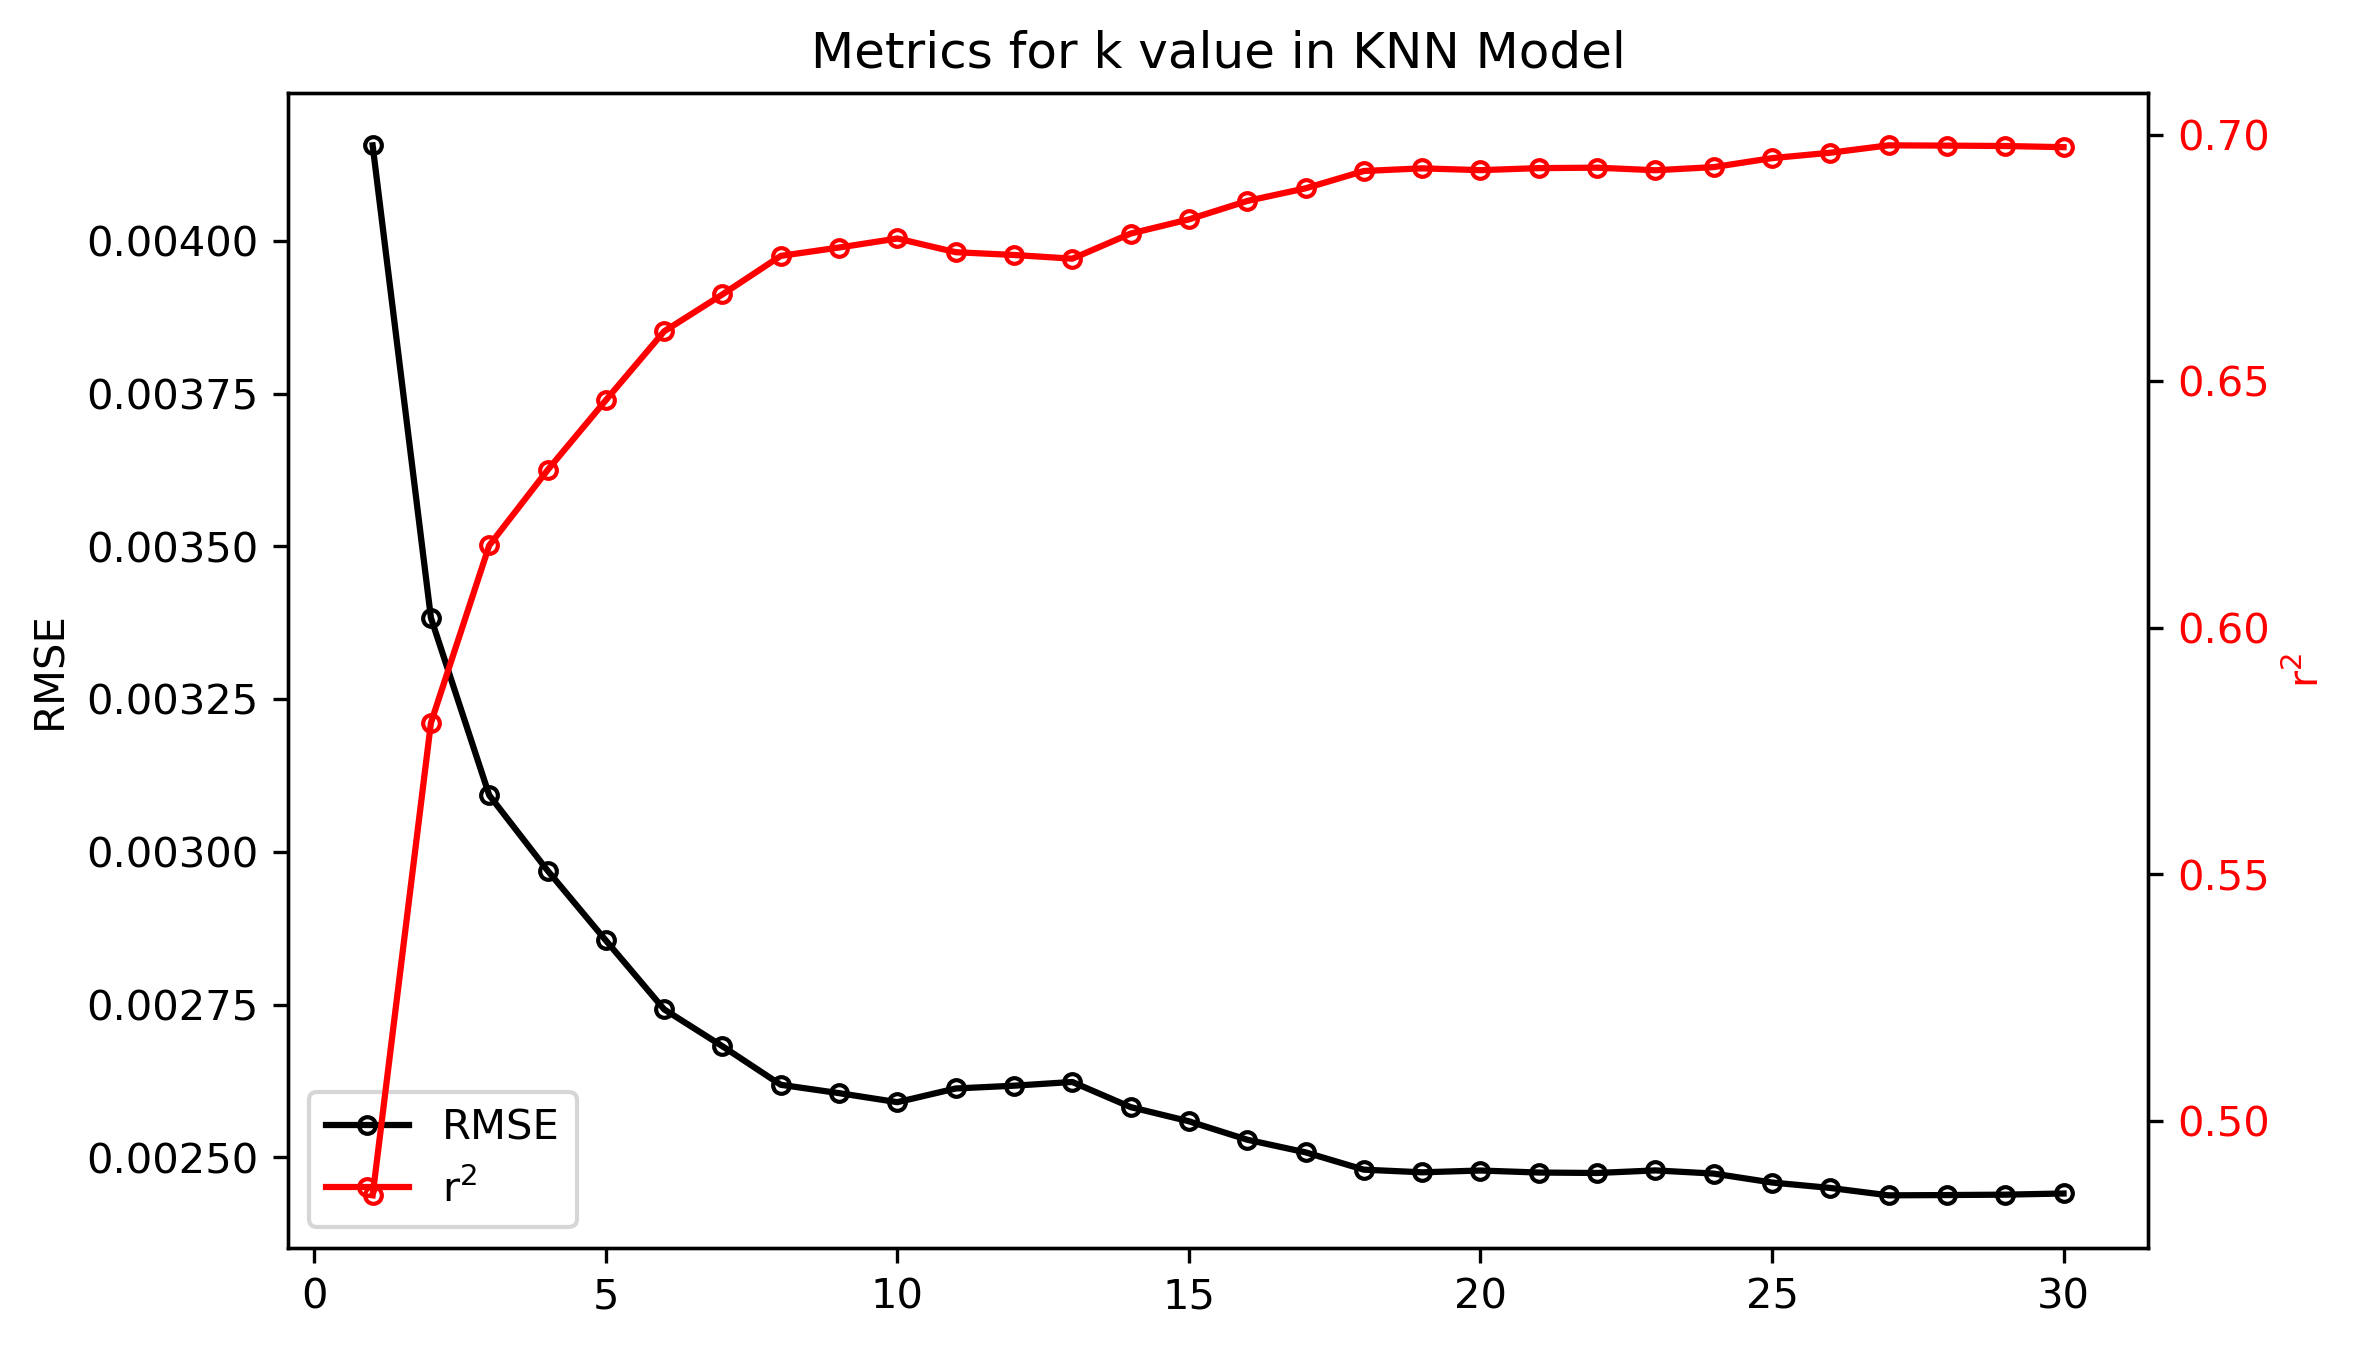

In [19]:
# because r^2 is a dictionary and not a list, separate them out and only get the r^2 values

r2_list = []

for a,b in scores.items():
#     print(a,'', b)
    r2_list.append(b)

# where k is the node and v is the r^2 values

fig, ax1 = plt.subplots(figsize = (8,5), dpi = 300, sharex = 'all')
ax2 = ax1.twinx() # twinx creates a new axes object ax2 that shares the same x-axis with ax1\

l1 = ax1.plot(k_range, MSE_list, 'o-k', markersize = 4 , markerfacecolor = 'none', label = 'RMSE')
ax1.set_ylabel(r'RMSE', color = 'k')
ax1.tick_params(axis='y', labelcolor = 'black')

l2 = ax2.plot(k_range, r2_list, 'o-r', markersize = 4, markerfacecolor = 'none', label = 'r$^{2}$')
ax2.set_ylabel(r'r$^{2}$', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
ax2.set_xlabel('# of nodes')


lns = l1 + l2
labs = [l.get_label() for l in lns]

plt.title('Metrics for k value in KNN Model')
ax1.legend(lns, labs, loc = 'lower left')

Choose a number for k: 15
r2 Train score: 0.68


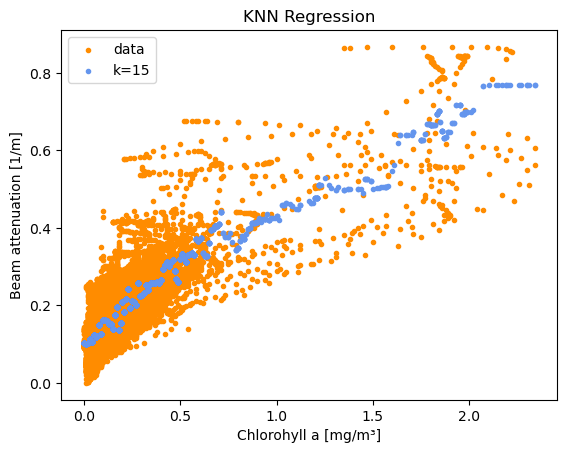

Accuracy Test Score:  0.6974909178092097


In [20]:
#### Pick a value for k based on the RMSE and r^2 

n  = int(input('Choose a number for k: '))


# Fit regression model
knn_final = KNeighborsRegressor(n_neighbors=n)
knn_final.fit(X_train, y_train)
print("r2 Train score: {0:.2f}".format(knn_final.score(X_train, y_train)))

# Predict
y_pred_final = knn_final.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, marker = '.', c="darkorange", label="data")
plt.scatter(X_test, y_pred_final, marker = '.', color="cornflowerblue", label="k="+str(n))
plt.xlabel('Chlorohyll a [mg/m\u00b3]')
plt.ylabel('Beam attenuation [1/m]')
plt.title('KNN Regression')
plt.legend()
plt.show()


# print the score
print('Accuracy Test Score: ', knn.score(X_test, y_test))

r2 = 0.678287929818293
r2 = 0.6828459016851065
MSE = 0.0025591592402669856


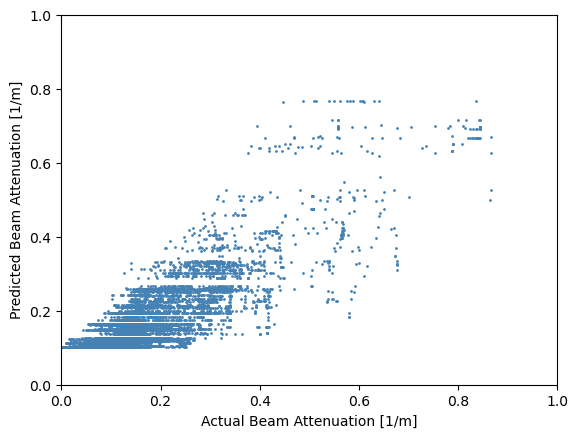

In [21]:
print('r2 =', r2_score(y_train, knn_final.predict(X_train))) # r2 between training datasets
print('r2 =', r2_score(y_test, y_pred_final)) # r2 between testing dataset and predicted value
print('MSE =',mean_squared_error(y_test, y_pred_final))

plt.plot(y_test, y_pred_final, 'o', markersize = 1, c='steelblue')
plt.xlabel('Actual Beam Attenuation [1/m]')
plt.xlim([0, 1])
plt.ylabel('Predicted Beam Attenuation [1/m]')
plt.ylim([0, 1])

plt.show()

# Applying a shuffled k-fold cross validation after the simple test/train split

In [22]:
n  = int(input('Choose a number for k: '))

# Fit regression model
knn_fold = KNeighborsRegressor(n_neighbors=n)


## Import k fold and cross validation score and prediction
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


## Create StratifiedKFold object.
kf = KFold(n_splits=5, shuffle=True, random_state=1)  # setting shuffle=True will shuffle the data before splitting into batches


## use k-fold CV to evaluate model
scores = cross_val_score(knn_fold, X, y, scoring=None, cv=kf) # scoring= none returns the default score for knn


Choose a number for k: 15


In [23]:
# Create empty lists to append in the for loop 
folds = []
train_list = []
test_list = []
y_pred_fold = []
residuals = []


for i, (train_index, test_index) in enumerate(kf.split(X)):
    # adds i to the fold to indicate which array belongs to which fold later
    folds.append(i)
    
    # Puts all the train and test indices in a list....one array for each fold
    train_list.append(train_index)
    test_list.append(test_index)
       
    # Calculate predictions from this model
    knn_fold.fit(X.loc[train_list[i]], y.loc[train_list[i]])
    y_pred_fold.append(knn_fold.predict(X.loc[test_list[i]]))
    
    # Calculate residuals for each fold:  actual - predicted
    residuals.append(y.loc[test_list[i]] - y_pred_fold[i])
    
    # Print the Indexes for each train and test set within each fold
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")



Fold 0:
  Train: index=[    1     2     3 ... 22683 22684 22685]
  Test:  index=[    0     4     6 ... 22672 22680 22681]
Fold 1:
  Train: index=[    0     1     2 ... 22683 22684 22685]
  Test:  index=[    5     8    12 ... 22678 22679 22682]
Fold 2:
  Train: index=[    0     1     2 ... 22682 22684 22685]
  Test:  index=[   17    34    36 ... 22670 22676 22683]
Fold 3:
  Train: index=[    0     4     5 ... 22682 22683 22684]
  Test:  index=[    1     2     3 ... 22671 22673 22685]
Fold 4:
  Train: index=[    0     1     2 ... 22682 22683 22685]
  Test:  index=[   14    15    18 ... 22665 22668 22684]


In [24]:
print('The r\u00b2 of each fold using a K Nearest Neighbor Regression is: ', scores)

## mean
print('The mean r\u00b2 of all folds is: ', np.mean(abs(scores)))


r2_scores = pd.DataFrame(scores, columns=['r\u00b2'])

## Using DataFrame.insert() to add a column
r2_scores.insert(0, "Fold", ['1st','2nd','3rd','4th','5th'], True)


## print dataframe that displays the minimum beam attenuation valeus calculated for each cruise
r2_scores


The r² of each fold using a K Nearest Neighbor Regression is:  [0.63983158 0.62819951 0.64781934 0.64029878 0.64050553]
The mean r² of all folds is:  0.6393309480874583


,Fold,r²
0,1st,0.639832
1,2nd,0.628200
2,3rd,0.647819
3,4th,0.640299
4,5th,0.640506


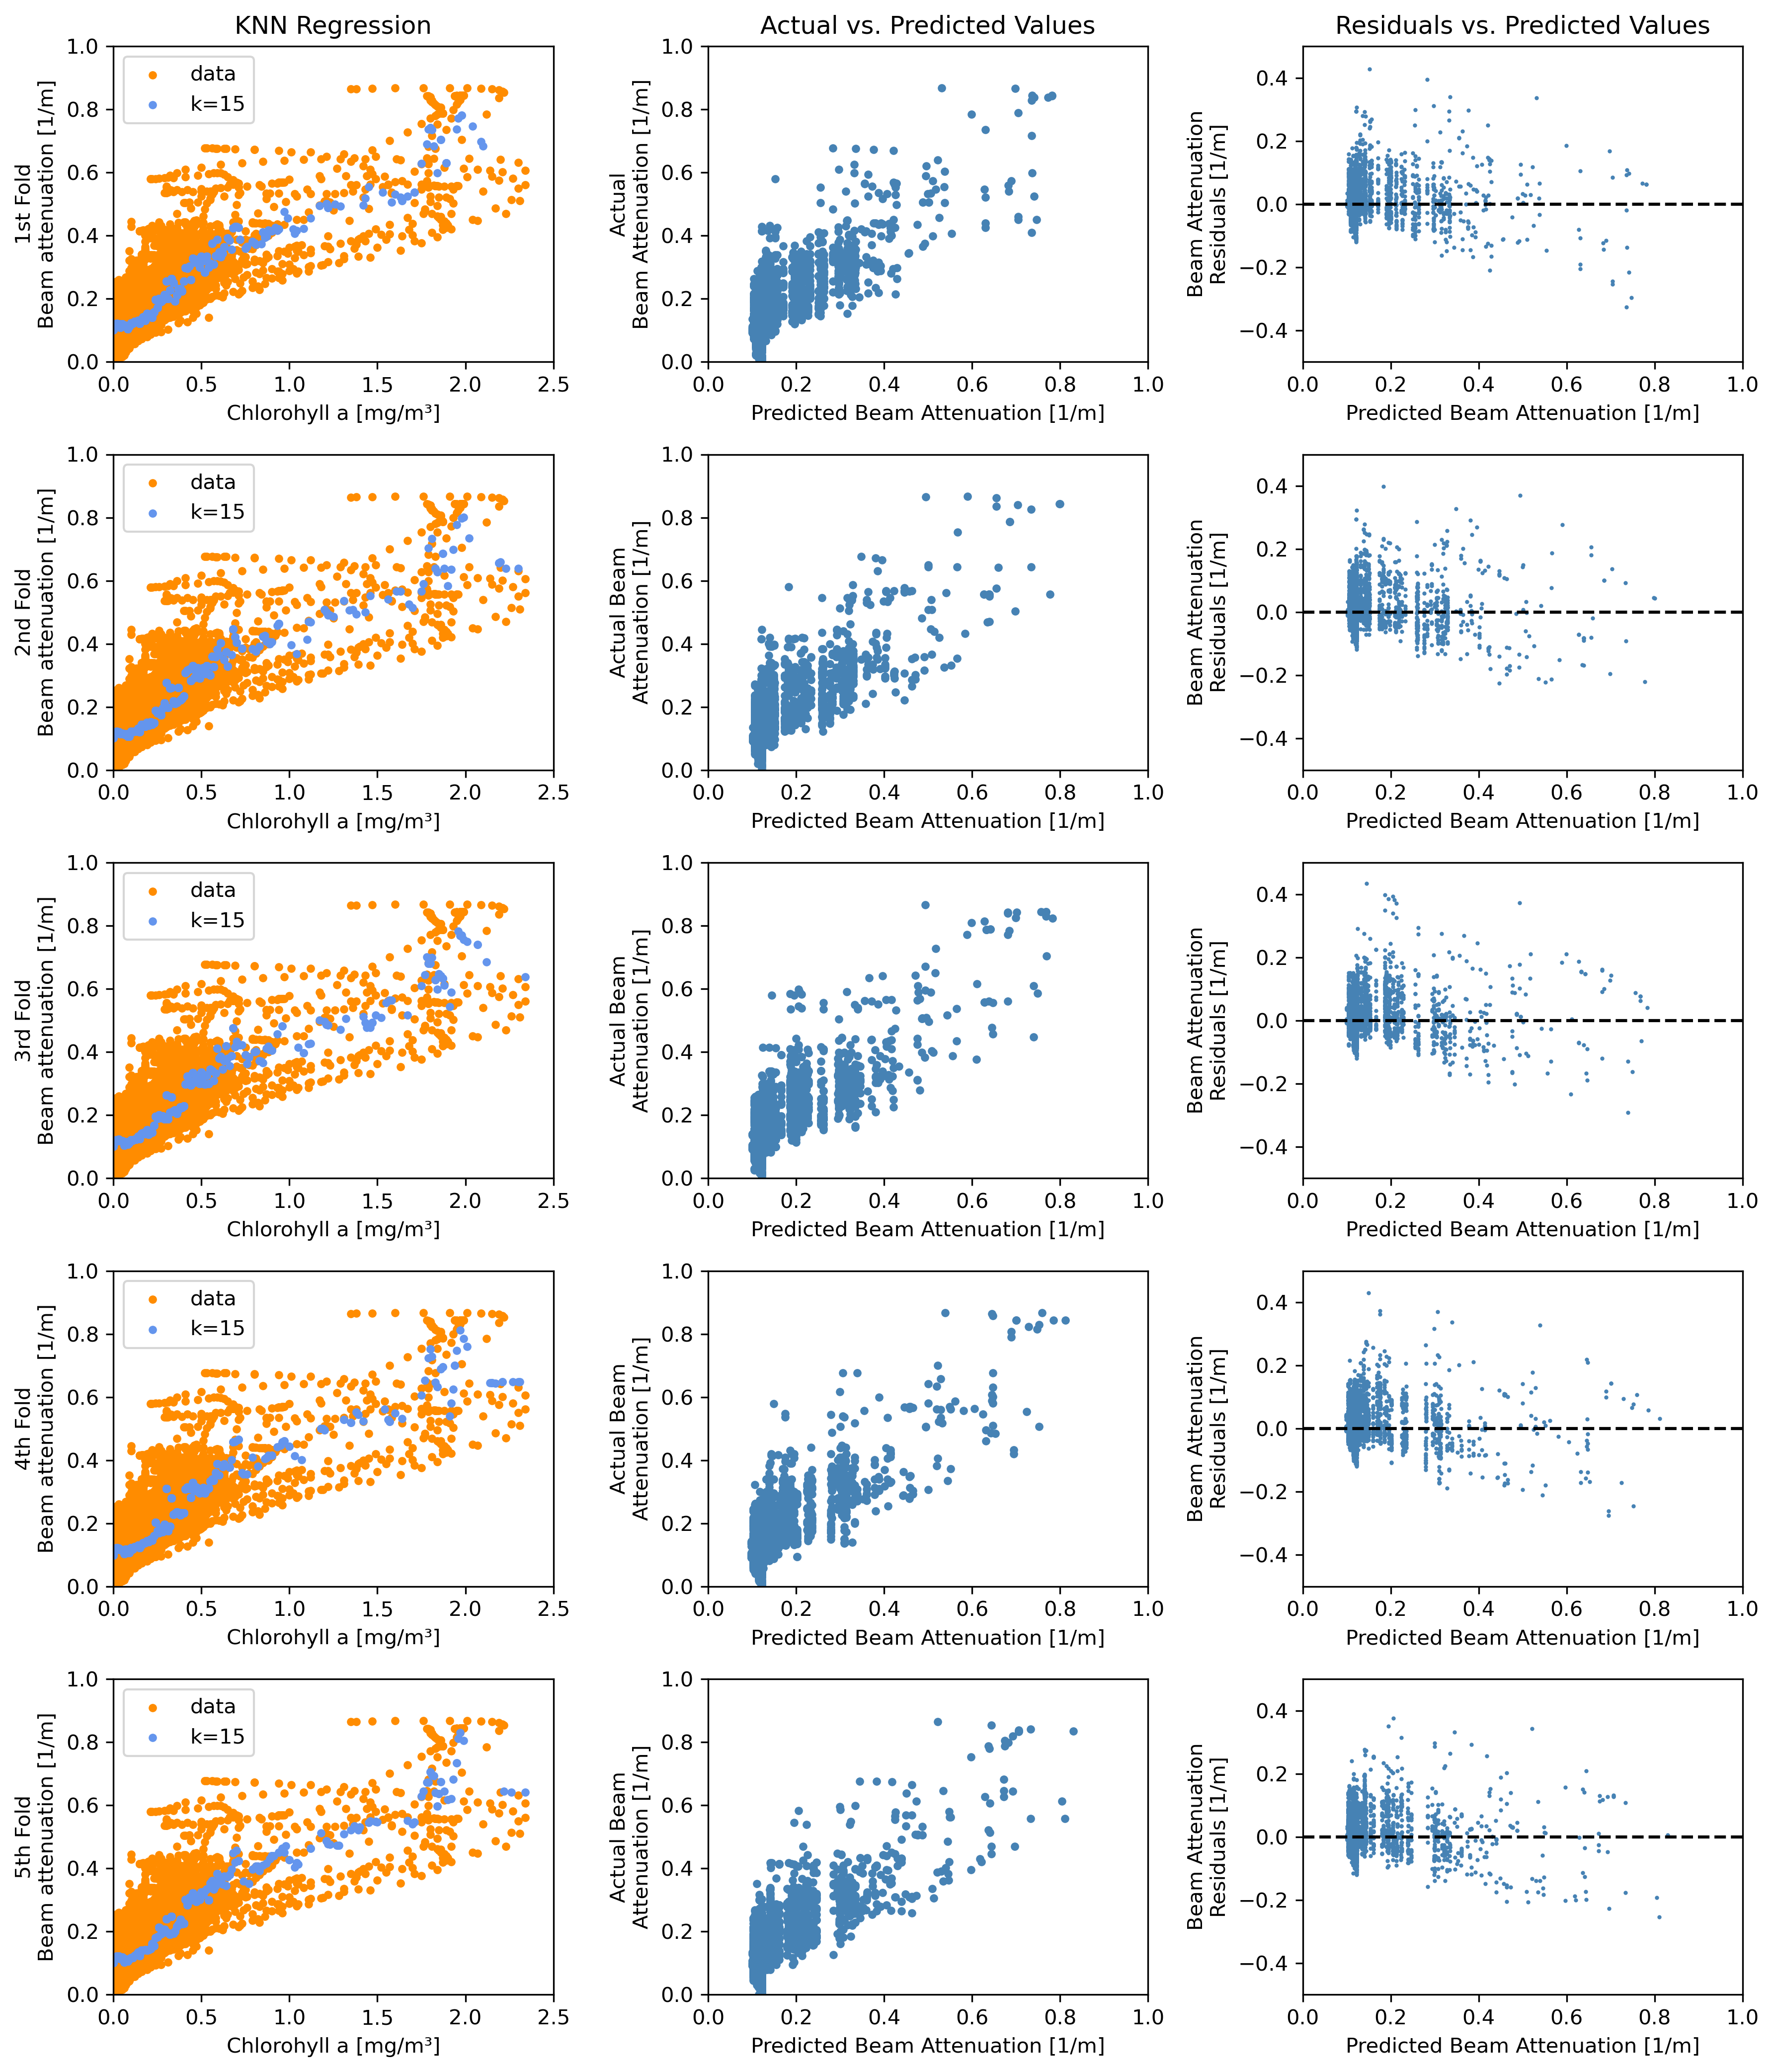

In [25]:
fig = plt.figure(figsize = (12,14), dpi = 300)


## 1st fold
ax1 = fig.add_subplot(5, 3, 1)
ax1.title.set_text('KNN Regression')
plt.scatter(X, y, marker = '.', c="darkorange", label="data")
plt.scatter(X.loc[test_list[0]], y_pred_fold[0], marker = '.', color="cornflowerblue", label="k="+str(n))
plt.xlabel('Chlorohyll a [mg/m\u00b3]')
plt.ylabel('1st Fold\nBeam attenuation [1/m]')
plt.xlim([0, 2.5])
plt.ylim([0, 1])
plt.legend()


ax2 = fig.add_subplot(5, 3, 2)
ax2.title.set_text('Actual vs. Predicted Values')
plt.scatter(y_pred_fold[0], y.loc[test_list[0]], marker = '.', c="steelblue")
plt.ylabel('Actual\nBeam Attenuation [1/m]')
plt.xlim([0, 1])
plt.xlabel('Predicted Beam Attenuation [1/m]')
plt.ylim([0, 1])


ax3 = fig.add_subplot(5, 3, 3)
ax3.title.set_text('Residuals vs. Predicted Values')
plt.plot(y_pred_fold[0], residuals[0], 'o', markersize = 1, c='steelblue')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Beam Attenuation [1/m]')
plt.xlim([0, 1])
plt.ylabel('Beam Attenuation\nResiduals [1/m]')
plt.ylim([-0.5, 0.5])


## 2nd fold
plt.subplot(5, 3, 4)
plt.scatter(X, y, marker = '.', c="darkorange", label="data")
plt.scatter(X.loc[test_list[1]], y_pred_fold[1], marker = '.', color="cornflowerblue", label="k="+str(n))
plt.xlabel('Chlorohyll a [mg/m\u00b3]')
plt.ylabel('2nd Fold\nBeam attenuation [1/m]')
plt.xlim([0, 2.5])
plt.ylim([0, 1])
plt.legend()


plt.subplot(5, 3, 5)
plt.scatter(y_pred_fold[1], y.loc[test_list[1]], marker = '.', c="steelblue")
plt.ylabel('Actual Beam\nAttenuation [1/m]')
plt.xlim([0, 1])
plt.xlabel('Predicted Beam Attenuation [1/m]')
plt.ylim([0, 1])


plt.subplot(5, 3, 6)
plt.plot(y_pred_fold[1], residuals[1], 'o', markersize = 1, c='steelblue')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Beam Attenuation [1/m]')
plt.xlim([0, 1])
plt.ylabel('Beam Attenuation\nResiduals [1/m]')
plt.ylim([-0.5, 0.5])


## 3rd fold
plt.subplot(5, 3, 7)
plt.scatter(X, y, marker = '.', c="darkorange", label="data")
plt.scatter(X.loc[test_list[2]], y_pred_fold[2], marker = '.', color="cornflowerblue", label="k="+str(n))
plt.xlabel('Chlorohyll a [mg/m\u00b3]')
plt.ylabel('3rd Fold\nBeam attenuation [1/m]')
plt.xlim([0, 2.5])
plt.ylim([0, 1])
plt.legend()


plt.subplot(5, 3, 8)
plt.scatter(y_pred_fold[2], y.loc[test_list[2]], marker = '.', c="steelblue")
plt.ylabel('Actual Beam\nAttenuation [1/m]')
plt.xlim([0, 1])
plt.xlabel('Predicted Beam Attenuation [1/m]')
plt.ylim([0, 1])


plt.subplot(5, 3, 9)
plt.plot(y_pred_fold[2], residuals[2], 'o', markersize = 1, c='steelblue')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Beam Attenuation [1/m]')
plt.xlim([0, 1])
plt.ylabel('Beam Attenuation\nResiduals [1/m]')
plt.ylim([-0.5, 0.5])


## 4th fold
plt.subplot(5, 3, 10)
plt.scatter(X, y, marker = '.', c="darkorange", label="data")
plt.scatter(X.loc[test_list[3]], y_pred_fold[3], marker = '.', color="cornflowerblue", label="k="+str(n))
plt.xlabel('Chlorohyll a [mg/m\u00b3]')
plt.ylabel('4th Fold\nBeam attenuation [1/m]')
plt.xlim([0, 2.5])
plt.ylim([0, 1])
plt.legend()


plt.subplot(5, 3, 11)
plt.scatter(y_pred_fold[3], y.loc[test_list[3]], marker = '.', c="steelblue")
plt.ylabel('Actual Beam\nAttenuation [1/m]')
plt.xlim([0, 1])
plt.xlabel('Predicted Beam Attenuation [1/m]')
plt.ylim([0, 1])


plt.subplot(5, 3, 12)
plt.plot(y_pred_fold[3], residuals[3], 'o', markersize = 1, c='steelblue')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Beam Attenuation [1/m]')
plt.xlim([0, 1])
plt.ylabel('Beam Attenuation\nResiduals [1/m]')
plt.ylim([-0.5, 0.5])


## 5th fold
plt.subplot(5, 3, 13)
plt.scatter(X, y, marker = '.', c="darkorange", label="data")
plt.scatter(X.loc[test_list[4]], y_pred_fold[4], marker = '.', color="cornflowerblue", label="k="+str(n))
plt.xlabel('Chlorohyll a [mg/m\u00b3]')
plt.ylabel('5th Fold\nBeam attenuation [1/m]')
plt.xlim([0, 2.5])
plt.ylim([0, 1])
plt.legend()


plt.subplot(5, 3, 14)
plt.scatter(y_pred_fold[4], y.loc[test_list[4]], marker = '.', c="steelblue")
plt.ylabel('Actual Beam\nAttenuation [1/m]')
plt.xlim([0, 1])
plt.xlabel('Predicted Beam Attenuation [1/m]')
plt.ylim([0, 1])


plt.subplot(5, 3, 15)
plt.plot(y_pred_fold[4], residuals[4], 'o', markersize = 1, c='steelblue')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Beam Attenuation [1/m]')
plt.xlim([0, 1])
plt.ylabel('Beam Attenuation\nResiduals [1/m]')
plt.ylim([-0.5, 0.5])


fig.tight_layout()
plt.show()